In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [2]:

# Path to your Excel file
excel_path = r'C:\Doc\stash\test-project\data1.xlsx'  # Use raw string to avoid unicode escape error
# Read all sheets into a dictionary of DataFrames
all_sheets = pd.read_excel(excel_path, sheet_name=None)
# Merge all sheets into one DataFrame, adding a column for sheet name
merged_df1 = pd.concat([df.assign(sheet_name=sheet) for sheet, df in all_sheets.items()], ignore_index=True)

# Path to your Excel file
excel_path = r'C:\Doc\stash\test-project\data2.xlsx'  # Use raw string to avoid unicode escape error
# Read all sheets into a dictionary of DataFrames
all_sheets = pd.read_excel(excel_path, sheet_name=None)
# Merge all sheets into one DataFrame, adding a column for sheet name
merged_df2 = pd.concat([df.assign(sheet_name=sheet) for sheet, df in all_sheets.items()], ignore_index=True)

df = pd.concat([merged_df1, merged_df2], ignore_index=True)

# Create a mapping dictionary between sheet names and sym values
sheet_to_sym = {
    'audusd': 'AUDUSD', 'c 1': 'C1', 'cl1': 'CL1', 'co1': 'CO1', 'eurusd': 'EURUSD', 'gbpusd': 'GBPUSD', 
    'gjgb1': 'GJGB1', 'gjgb10': 'GJGB10', 'gjgb30': 'GJGB30', 'gjgb5': 'GJGB5', 'hg1': 'HG1', 'hsi': 'HSI',
    'hxc': 'HXC', 'ihn+1m': 'USDIDR', 'irn+1m': 'USDINR', 'kc1': 'KC1', 'kwn+1m': 'USDKRW', 'la1': 'LA1', 
    'ndx': 'NDX', 'ng1': 'NG1', 'nky': 'NKY', 'ntn+1m': 'USDTWD', 'nzdusd': 'NZDUSD', 'ppn+1m': 'USDPHP', 
    'rr1': 'RR1', 'shcomp': 'SHCOMP', 'shsz300': 'SHSZ300', 'spx': 'SPX', 'ukx': 'UKX', 'usdcad': 'USDCAD', 
    'usdchf': 'USDCHF', 'usdcnh': 'USDCNH', 'usddxy': 'USDDXY', 'usdjpy': 'USDJPY', 'usdnok': 'USDNOK',
    'usdsek': 'USDSEK', 'usdsgd': 'USDSGD', 'usdthb': 'USDTHB', 'usgg10yr': 'US10', 'usgg12m': 'US1', 
    'usgg1m': 'US1M', 'usgg30yr': 'US30', 'usgg5yr': 'US5', 'w 1': 'W1', 'xag': 'XAGUSD', 
    'xau': 'XAUUSD', 'xbt': 'BTCUSD', 'xetusd': 'ETHUSD'
}

# Create a new column 'sym' using the mapping
df['sym'] = df['sheet_name'].map(sheet_to_sym)

In [3]:
asset_name = [
    'GJGB10', 'HSI', 'HXC', 'NDX', 'SPX', 'NKY', 'SHCOMP', 'SHSZ300', 'UKX', 'USDDXY', 
    'US10', 'US1M', 'US30', 'XAGUSD', 'XAUUSD'
 ]

# Select only relevant columns and rows for pivoting
df_selected = df[df['sym'].isin(asset_name)][['Date', 'sym', 'Close']]

# Pivot the DataFrame: index='Date', columns='sym', values='Close'
pivot_df = df_selected.pivot(index='Date', columns='sym', values='Close')

# Forward fill missing values and drop any remaining nulls
pivot_df_filled = pivot_df.ffill().dropna()
# Reset index so the key column (Date) becomes a normal column
pivot_df_final = pivot_df_filled.reset_index()

pivot_df_final['GJGB10'] = np.exp(-10*pivot_df_final['GJGB10']/100)
pivot_df_final['US10'] = np.exp(-10*pivot_df_final['US10']/100)
pivot_df_final['US1M'] = np.exp(-(1/12)*pivot_df_final['US1M']/100)
pivot_df_final['US30'] = np.exp(-30*pivot_df_final['US30']/100)

pivot_df_final.head()

sym,Date,GJGB10,HSI,HXC,NDX,NKY,SHCOMP,SHSZ300,SPX,UKX,US10,US1M,US30,USDDXY,XAGUSD,XAUUSD
0,2002-01-04,0.869097,11702.15,1351.74,1675.03,10871.49,1611.393,1316.46,1172.51,5323.8,0.598817,0.998576,0.189304,116.33,4.70,278.95
1,2002-01-07,0.870315,11892.64,1375.23,1649.83,10942.36,1596.760,1302.08,1164.89,5293.6,0.603566,0.998593,0.192743,116.33,4.71,278.75
2,2002-01-08,0.869445,11713.71,1394.96,1666.58,10695.60,1583.461,1292.71,1160.71,5250.4,0.601698,0.998584,0.190386,116.83,4.69,279.05
3,2002-01-09,0.870663,11440.72,1357.56,1653.76,10663.98,1561.349,1272.65,1155.14,5228.5,0.603445,0.998643,0.192223,117.01,4.82,283.95
4,2002-01-10,0.869793,11256.07,1329.60,1656.68,10538.43,1576.437,1281.26,1156.55,5190.7,0.607806,0.998609,0.196951,116.88,4.79,286.35


In [4]:
asset_cols = [col for col in pivot_df_final.columns if col != 'Date']
n_assets = len(asset_cols)
print(f'Number of assets: {n_assets}, Number of dates: {len(pivot_df_final)}')

Number of assets: 15, Number of dates: 6110


In [5]:
# Set Date as index for easier slicing
prices = pivot_df_final.set_index('Date')[asset_cols]

# Compute daily log returns (full dataset)
returns_full = np.log(prices / prices.shift(1)).dropna()

In [14]:
# Step 2: Function to compute PCA-based mu and sigma
def compute_pca_mu_sigma(returns_window):
    if len(returns_window) < n_assets:
        return None, None
    
    scaler = StandardScaler()
    returns_scaled = scaler.fit_transform(returns_window)
    
    pca = PCA()
    pca.fit(returns_scaled)
    explained_var = np.cumsum(pca.explained_variance_ratio_)
    n_factors = np.argmax(explained_var >= 0.8) + 1 or 1
    
    pca = PCA(n_components=n_factors)
    pca.fit(returns_scaled)
    
    betas = pca.components_.T
    factor_returns = pca.transform(returns_scaled)
    residuals = returns_scaled - np.dot(factor_returns, pca.components_)
    idio_vars = np.var(residuals, axis=0)
    
    factor_cov = np.diag(pca.explained_variance_)
    
    mu = np.mean(returns_window, axis=0).values
    sys_cov = np.dot(betas, np.dot(factor_cov, betas.T))
    scale_matrix = np.outer(scaler.scale_, scaler.scale_)
    sys_cov_original = sys_cov * scale_matrix
    idio_vars_original = idio_vars * scaler.scale_**2
    sigma = sys_cov_original + np.diag(idio_vars_original)
    
    return mu, sigma

In [15]:
# Step 3: MVO function
def negative_sharpe(weights, mu, sigma):
    port_return = np.dot(weights, mu)
    port_std = np.sqrt(np.dot(weights.T, np.dot(sigma, weights)))
    return -port_return / port_std if port_std > 0 else np.inf

def compute_optimal_weights(mu, sigma):
    if mu is None or sigma is None:
        return np.full(n_assets, np.nan)
    
    constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
    bounds = tuple((0, 1) for _ in range(n_assets))
    initial_weights = np.ones(n_assets) / n_assets
    opt_result = minimize(negative_sharpe, initial_weights, args=(mu, sigma),
                          method='SLSQP', bounds=bounds, constraints=constraints)
    return opt_result.x if opt_result.success else np.full(n_assets, np.nan)

In [16]:
# Step 4: Rolling analysis (use D-60 to D-1 for day D)
weight_cols = ['Weight_' + col for col in asset_cols]
weights_df = pd.DataFrame(index=prices.index, columns=weight_cols, dtype=float)
window_size = 60

for i in range(window_size, len(prices)):
    end_date = prices.index[i-1]  # Use D-1 as last day
    start_date = prices.index[i-window_size] if i >= window_size else None
    if start_date is None:
        continue
    
    window_prices = prices.loc[start_date:end_date]
    returns_window = np.log(window_prices / window_prices.shift(1)).dropna()
    
    if len(returns_window) < window_size - 1:
        continue
    
    mu, sigma = compute_pca_mu_sigma(returns_window)
    weights = compute_optimal_weights(mu, sigma)
    weights_df.loc[prices.index[i]] = weights  # Assign to day D

In [21]:
# Step 5: Add weight columns back to original pivot_df_final
updated_df = pivot_df_final.set_index('Date').join(weights_df).reset_index()

# Display or save the updated table
print(updated_df.tail())  # Preview

           Date    GJGB10       HSI      HXC       NDX       NKY    SHCOMP  \
6105 2025-06-04  0.860192  23654.03  7254.51  21721.92  37747.45  3376.203   
6106 2025-06-05  0.863553  23906.97  7293.84  21547.43  37554.49  3384.098   
6107 2025-06-06  0.864590  23792.54  7289.42  21761.79  37741.61  3385.358   
6108 2025-06-07  0.864590  23792.54  7289.42  21761.79  37741.61  3385.358   
6109 2025-06-09  0.864590  23792.54  7289.42  21761.79  37741.61  3385.358   

      SHSZ300      SPX      UKX  ...  Weight_SHCOMP  Weight_SHSZ300  \
6105  3868.74  5970.81  8801.29  ...   0.000000e+00    0.000000e+00   
6106  3877.56  5939.30  8811.04  ...   9.844272e-17    3.220323e-16   
6107  3873.98  6000.36  8837.91  ...   3.740872e-17    2.484344e-17   
6108  3873.98  6000.36  8837.91  ...   1.710465e-16    1.074852e-16   
6109  3873.98  6000.36  8837.91  ...   1.428522e-16    0.000000e+00   

        Weight_SPX  Weight_UKX   Weight_US10  Weight_US1M   Weight_US30  \
6105  2.636228e-16    0.02655

In [22]:
updated_df.tail()

,Date,GJGB10,HSI,HXC,NDX,NKY,SHCOMP,SHSZ300,SPX,UKX,...,Weight_SHCOMP,Weight_SHSZ300,Weight_SPX,Weight_UKX,Weight_US10,Weight_US1M,Weight_US30,Weight_USDDXY,Weight_XAGUSD,Weight_XAUUSD
6105,2025-06-04,0.860192,23654.03,7254.51,21721.92,37747.45,3376.203,3868.74,5970.81,8801.29,...,0.000000e+00,0.000000e+00,2.636228e-16,0.026554,2.619455e-17,0.006593,0.000000e+00,7.824828e-17,0.0,0.235550
6106,2025-06-05,0.863553,23906.97,7293.84,21547.43,37554.49,3384.098,3877.56,5939.30,8811.04,...,9.844272e-17,3.220323e-16,0.000000e+00,0.028092,0.000000e+00,0.000139,8.556782e-17,0.000000e+00,0.0,0.173175
6107,2025-06-06,0.864590,23792.54,7289.42,21761.79,37741.61,3385.358,3873.98,6000.36,8837.91,...,3.740872e-17,2.484344e-17,0.000000e+00,0.008637,0.000000e+00,0.001183,0.000000e+00,0.000000e+00,0.0,0.204054
6108,2025-06-07,0.864590,23792.54,7289.42,21761.79,37741.61,3385.358,3873.98,6000.36,8837.91,...,1.710465e-16,1.074852e-16,0.000000e+00,0.028635,0.000000e+00,0.001444,0.000000e+00,0.000000e+00,0.0,0.160760
6109,2025-06-09,0.864590,23792.54,7289.42,21761.79,37741.61,3385.358,3873.98,6000.36,8837.91,...,1.428522e-16,0.000000e+00,0.000000e+00,0.040699,0.000000e+00,0.000260,0.000000e+00,0.000000e+00,0.0,0.149546


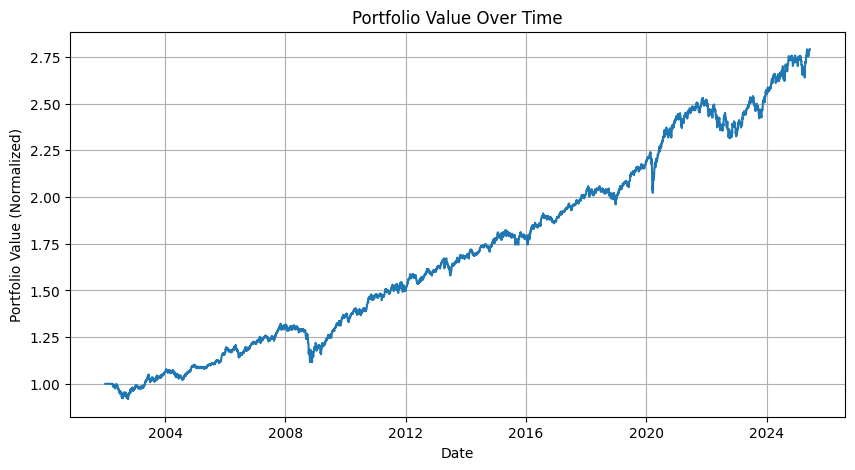

In [ ]:
updated_df['Portfolio_Value'] = 1.0

asset_cols = [col for col in updated_df.columns if col not in ['Date', 'Portfolio_Value'] and not col.startswith('Weight_')]
weight_cols = ['Weight_' + col for col in asset_cols]

for i in range(window_size, len(updated_df)):
    prices_today = updated_df.iloc[i][asset_cols].values
    prices_yest = updated_df.iloc[i-1][asset_cols].values
    daily_returns = (prices_today / prices_yest) - 1
    port_return = np.sum(weights * daily_returns)
    updated_df.iloc[i, updated_df.columns.get_loc('Portfolio_Value')] = updated_df.iloc[i-1]['Portfolio_Value'] * (1 + port_return)

plt.figure(figsize=(10, 5))
plt.plot(updated_df['Date'], updated_df['Portfolio_Value'])
plt.xlabel('Date')
plt.ylabel('Portfolio Value (Normalized)')
plt.title('Portfolio Value Over Time')
plt.grid(True)
plt.show()

In [36]:
port_re = np.log(updated_df['Portfolio_Value'] / updated_df['Portfolio_Value'].shift(1) )

print('Annual return is '+str(np.round(100*252*np.mean(port_re),2)) + '%, Sharpe is '\
      + str(np.round(np.sqrt(252)*np.mean(port_re) / np.std(port_re),2)))



Annual return is 4.23%, Sharpe is 0.83
